# Artifical Neural Network design from scratch using numpy (ANN)


Let's design a neural network that can be parameterized to form shallow or deep neural network. Following are some of the typical parameters that can be tuned.
- Number of layers, units and their activation functions with options of sigmoid, tanh, relu and leaky relu. We can define softmax function for multi class classifier.
- Optimizers like Gradient Descent, Gradient Descent with momentum, RMSprop and Adam
- Batch/Mini batch/Stochastic Gradient
- Learning rate Decay for better optimization
- L2 regularization and Drop out regularization methods

We will use a simple petal dataset to train and predict, form decision boundary. This will help us to understand how much Neuralnet is capable of understanding the nonlinear region where traditional machine learning algorithm struggles.


#### Import required python packages

In [29]:
# Numpy package for numerical operation
import numpy as np

# Matplotlin for plots
from matplotlib import pyplot as plt

# Set seed for stabilized result
np.random.seed(1)

#### Dataset for training neural network

In [30]:
# Create a dataset have coordinates for flower petals classified in two category
# We are creating a dataset that would be easy to visualize and train

def gen_petal_dataset(): 
    np.random.seed(1) # for stabilized result
    m = 400 # number of data points
    D = 2 # number of class
    N = int(m/D) # number of data points per class      
    X = np.zeros([m,D]) # data matrix where each row is a single example 
    Y = np.zeros([m,1], dtype='uint8') # labels petals (0 for red, 1 for blue) 
    a = 4 # maximum petals of the flower per class
  
 
    for j in range(2): # For 2 classes
        ix = range(N*j,N*(j+1)) # Row indexes for data points
        t = np.linspace(j*np.pi,(j+1)*np.pi,N) + np.random.randn(N)*0.2 # theta with some noise
        r = 4*np.sin(a*t) + np.random.randn(N)*0.2 # sinosoidal radius with some noise
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)] # Convert polar co-ordinates to cartesian co-ordinates
        Y[ix] = j # Copy the class
         
    X = X.T # Transpose the matrix to have rows as co-ordinate pairs and columns as data-points
    Y = Y.T # Transpose in accordance with X
  
    return X, Y 

# Load the dataset
X,Y=gen_petal_dataset()

#### Plot the dataset

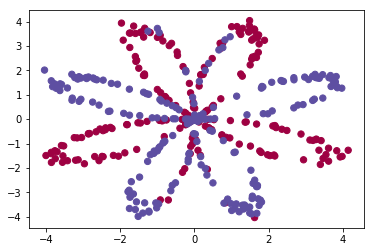

In [31]:
# plot the dataset - petals of the flower
plt.scatter(X[0, :], X[1, :], c = np.squeeze(Y), s=40, cmap=plt.cm.Spectral);

#### Define functions to build neural network


**Parameter initialization**
- layers : list of number of units in each layer from 0 to L where L is total number of layers
- Forward values : Values used in forward propagation. Initialize W using Xavier's initialization to avoid exploding or vanishing gradient
    $W^l = \frac{1}{\sqrt{n^{l-1}}} \times \mathcal{N~(0,1)}_{[n^l,n^{l-1}]} $
- Backward grads : Values used in backward propagation

In [32]:
# Initialize learnable parameters W and b
def initialize_parameter(parameters):
    layers = parameters['layers']     
    W={}; b={}; Z={}; A={}; D= {};    
    dW={}; db={}; dZ={}; dA={};    
    VdW={}; Vdb={}; SdW={}; Sdb={};
    np.random.seed(2)     # for stability of results
    for layer in range(len(layers))[1:]:  # Initilize W, b randomly with values close to 0
        # Xaviers initialization for W
        W[layer] = (1/np.sqrt(layers[layer-1]))*np.random.randn(layers[layer],layers[layer-1])
        b[layer] = np.random.randn(layers[layer],1)*0.01
        assert(W[layer].shape==(layers[layer],layers[layer-1]))
        assert(b[layer].shape==(layers[layer],1))
        
    
    # Values for forward propagation
    forward_values = [W, b, Z, A, D]  
    
    # Gradients for Backward propagation
    backward_grads = {}
    backward_grads['dW'] = dW 
    backward_grads['db'] = db
    backward_grads['dZ'] = dZ
    backward_grads['dA'] = dA
    backward_grads['VdW'] = VdW 
    backward_grads['Vdb'] = Vdb
    backward_grads['SdW'] = SdW 
    backward_grads['Sdb'] = Sdb
    
    return(forward_values,backward_grads)


**Activation function**
- Define activation function for sigmoid, tanh, relu and leaky-relu
- Sigmoid function $g(z) = \frac{1}{1+e^{-z}}$
- Tanh function $g(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}}$
- Relu function $g(z) = max(0, z)$
- Leaky relu function $g(z) = max(0.01z, z)$
- Softmax function (for multiclass output - usually more than two) $g(z) = \frac{e^{z}}{\sum^{L_n}e^{z}}$


In [33]:
# Activation function 
def activation(z, g):
    if g == 'sigmoid':
        result = 1/(1+np.exp(-z))
    elif g == 'relu':
        result = z*(z>0)
    elif g == 'lrelu':
        result = z*(z>0) + 0.01*z*(z<0)
    elif g == 'tanh':
        result = np.tanh(z)
    elif g == 'softmax':
        result = np.exp(z)/np.exp(z).sum()
    else :
        result = z
    assert(z.shape == result.shape)
    return(result)


**Gradient function for activations**
- For each activation function mentioned above, define function to evaluate its gradient
- Gradient of Sigmoid function $g'(z) = g(z)(1-g(z))$
- Gradient of Tanh function $g'(z) = 1-g(z)^2$
- Gradient of Relu function $g'(z) = 1$  when $z >= 0$ and $g'(z) = 0$ when $z < 0$
- Gradient of Leaky relu function $g'(z) = 1$ when $z >= 0$  and  $g'(z) = 0.01$ when $z < 0$
- Gradient of Softmax function $g'(z) = \frac{((\sum^{L_n}e^{z}) - e^{z}) e^{z}}{(\sum^{L_n}e^{z})^2}$

**Note:** Mathematically, gradient of relu and leaky relu is NOT defined at 0 however here we assume 1 

In [34]:
# Activation_gradient function 
def activation_gradient(z, g):
    if g == 'sigmoid':
        activ_out = activation(z,g)
        result = np.multiply(activ_out,(1-activ_out))
    elif g == 'relu':
        result = 1*(z>0)
    elif g == 'lrelu':
        result = 1*(z>0) + 0.01*(z<0)
    elif g == 'tanh':
        activ_out = activation(z,g)
        result = 1-np.power(activ_out,2)
    elif g == 'softmax':
        result = (np.exp(z).sum()-np.exp(z))*(np.exp(z))/(np.exp(z).sum())**2
    else :
        result = np.ones(z.shape)
    assert(z.shape == result.shape)
    return(result)


**Forward propagation** is propagating values from Input layer , through different layers with initiliazed parameters, to output layer. Below is what we calculate in each layer
- $Z^{[l]}=W^{[l]}.A^{[l-1]}+b^{[l]}$ 
- $A^{[l]}=g(Z^{[l]})$ 

where $Z$ and $A$ are matrixs with $m$ columns,
   - $.$ is dot product
   - $A$ is the activation value of each layer
   - $g()$ is the activation function.
   - $Z$ is input to activation units
   - $W$ is weights and b is the bias for each layer
   - $l$(layer) is the layer that ranges from 0 to L(total number of layers)
   - $m$ is the number of data points inputted into the system
   - $X$ is the input and also the 0th layer activation values, i.e $A^{[0]}$ 
   - $G$ is the list of activation function layerwise
    
- Propagation of values $A^{[0]}$ &rarr; $Z^{[1]}$ &rarr; $A^{[1]}$ &rarr; ... &rarr; $Z^{[l]}$ &rarr; $A^{[l]}$ &rarr; ... &rarr; $Z^{[L]}$ &rarr; $A^{[L]}$
- For drop out regularisation, switch off certain neural units of hidden layer based on keep_prob paramater. So $A^{[l]} = A^{[l]} * D^{[l]}$ where $D^{[l]}$ has same dimension as $A^{[l]}$ and value wise it has "keep_prob" percentage of Trues (1) and rest as False (0) during training while during prediction all units are to be active

In [35]:
# Forward propagation
def forward_propagation(X, parameters, forward_values):    
    layers = parameters['layers'] 
    G = parameters['activations'] 
    keep_prob = parameters['keep_prob'] 
    W, b, Z, A, D = forward_values    
    for layer in range(len(layers)):
        if layer == 0 :            
            Z[layer] = np.nan            
            A[layer] = X
        else :
            Z[layer] = np.dot(W[layer],A[layer-1]) + b[layer]
            A[layer] = activation(Z[layer],G[layer])
            assert(Z[layer].shape == (layers[layer],X.shape[1]))
            assert(A[layer].shape == (layers[layer],X.shape[1]))
            if (layer != len(layers)-1) & (keep_prob < 1.0):
                D[layer] = np.random.rand(A[layer].shape[0],A[layer].shape[1]) <= keep_prob
                A[layer] = A[layer]*D[layer]
    forward_values = W, b, Z, A, D
    return(forward_values)


**Cost function** evaluates the cost of predicting output value incorrectly.
- Cost is evaluated as average value of loss, i.e. $(1/m)$ of Loss 
- For single output unit predicting 2 class, this is evaluated as 
- $(1/m)(-1) \sum^{m} (YlogY' + (1-Y)log(1-Y'))$
- For multiple output units predicting more than 1 class, this is evaluated as 
- $(1/m)(-1) \sum^{m} \sum^{L_n}YlogY'$
    - $L_n$ are $n$ units in $L^{th}$ layer
    - $Y$ is the actual output. 
    - $Y'$ is predicted output of last layer based on forward propagation after an iteration. This is also same as $A^{[L]}$
- In case you opt for L2-regularization, the cost factor would have additional value evaluated as $L_2 = \frac{\lambda}{2m} \times \sum_{l=1}^{l=L}||W^{[l]}||_2 $ where $||W^{[l]}||_2$ is Frobenius norm of $W^{[l]}$




In [36]:
# Cost function
def cost_function(X, Y, parameters, forward_values):
    layers = parameters['layers'] 
    lambd = parameters['lambda_R2']
    bch = parameters['batch_size'] 
    W, b, Z, A, D = forward_values
    output_units = layers[-1]
    L = len(layers)-1
    e = 1e-8 # To avoid divide by 0 error
    if bch == 0 :
        Yhat = A[L]
    else :        
        forward_val = W.copy(), b.copy(), Z.copy(), A.copy(), D.copy()
        forward_val = forward_propagation(X, parameters, forward_val)        
        _, _, _, Afull, _ = forward_val
        Yhat = Afull[L]
    m = Y.shape[1]
    if output_units == 1:
        loss = np.multiply(-1,np.multiply(Y,np.log(Yhat+e)) + np.multiply(1-Y,np.log(1-Yhat+e)))
    else:
        loss = np.multiply(-1,np.sum(Y*np.log(Yhat+e)))    
    cost = np.multiply((1/m),np.sum(loss))
    if lambd != 0 : # L2-regularization
        for layer in range(len(layers))[1:]:
            cost = cost + (lambd/2/m)*(np.linalg.norm(W[layer])**2)
    assert(isinstance(cost,float))
    return(cost)


**Loss gradient function** ($dA^{[L]}$) is gradient of loss function
- For single output unit predicting 2 class, this is evaluated as 
- $(-1) \sum^{m} (\frac{Y}{Y'} - \frac{(1-Y)}{(1-Y')}) = \sum^{m}\frac{(Y'-Y)}{Y'(1-Y')}$ or $\sum^{m}\frac{(A^{[L]}-Y)}{A^{[L]}(1-A^{[L]})}$ 
- For multiple output units predicting more than 1 class, this is evaluated as 
- $(-1) \sum^{m} \sum^{L_n} \frac{Y}{Y'}$ or $(-1) \sum^{m} \sum^{L_n} \frac{Y}{A^{[L]}}$
- In case you opt for L2-regularization, the additional cost factor $L_2$ would need to be factor in however since this term is sum of square of weights (i.e. Frobenius norm of weights) in each layer, the change in $L_2$ would be evaluated while calculating $dW^{[l]}$ for each layer (i.e instead of differentiating $L_2$ term during each step of a backward propagation, only do it while calculating  $dW^{[l]}$). Though this approach would mean the gradient of all other terms except $dW^{[l]}$ doesn't factor in $L_2$ term, it doesn't impact the overall backward propagation calculation.


In [37]:
# Loss Gradient
def loss_gradient(Y, parameters, forward_values):
    layers = parameters['layers'] 
    _, _, _, A, _ = forward_values
    output_units = layers[-1]
    e = 1e-8  # To avoid divide by 0 error
    L = len(layers)-1
    if output_units == 1:
        dloss = (e+A[L]-Y)/np.multiply(e+A[L],(e+1-A[L]))
    else:
        dloss = np.multiply(-1,np.sum(Y/A[L]))
    assert(dloss.shape == A[L].shape)
    return(dloss)

**Backward propagation** is propagating gradient in the backward direction. We would start with loss gradient, propagating it through output layer, hidden layer to first layer. During propagation, we would also find gradient for parameters $W$ and $b$ - they are $dW$ and $db$.
- $dA^{[L]} = $ Loss gradient function 
- $dZ^{[L]} = dA^{[L]} * g'(Z^{[L]})$  
- $dA^{[L-1]} = W^{[L]T}.dZ^{[L]}$
    - where $*$ is element-wise product, $.$ is dot product and $W^{[L]T}$ is transpose of $W^{[L]}$  
- Use $dA[l] = dA[l] * D[l]$ where $D[l]$ is carried from forward propagation. This is for drop out regularization.
- The propagation is $dA^{[L]}$ &rarr; $dZ^{[L]}$ &rarr; ... &rarr; $dA^{[l]}$ &rarr; $dZ^{[l]}$ &rarr; ... &rarr; $dA^{[1]}$
- As by product of backward propagation, gradients $dW$ and $db$ are evaluated as
- $dW^{[l]} = \frac{1}{m} dZ^{[l]}.A^{[l-1]T}$ 
- $db^{[l]} = \frac{1}{m} \sum^{columns} dZ^{[l]}$
- If you opt for L2 regularization, evaluation of $dW^{[l]}$ would include include addtional term so equation becomes $dW^{[l]} = \frac{1}{m} dZ^{[l]}.A^{[l-1]T} + \frac{\lambda}{m} W^{[l]}$


**Note** : $dX$ denotes $\frac{\partial \mathcal{L}}{\partial X}$ , e.g. $dA^{[L]}$ is same as $\frac{\partial \mathcal{L}}{\partial A^{[L]}}$

In [38]:
# Backward propagation
def backward_propagation(Y, parameters, forward_values, backward_grads):    
    
    layers = parameters['layers'] 
    G = parameters['activations'] 
    alpha = parameters['alpha'] 
    keep_prob = parameters['keep_prob'] 
    lambd = parameters['lambda_R2']
    
    W, b, Z, A, D = forward_values     
    
    # Gradients for Backward propagation
    dW = backward_grads['dW']
    db = backward_grads['db']
    dZ = backward_grads['dZ']
    dA = backward_grads['dA']
    VdW = backward_grads['VdW']
    Vdb = backward_grads['Vdb']
    SdW = backward_grads['SdW']
    Sdb = backward_grads['Sdb']
    
    m = Y.shape[1]
    
    for layer in reversed(range(len(layers))[1:]):                
        if layer == len(layers)-1 :
            dA[layer] = loss_gradient(Y, parameters, forward_values)
            dZ[layer] = np.multiply(dA[layer], activation_gradient(Z[layer],G[layer]))
        else :
            dA[layer] = np.dot(W[layer+1].T,dZ[layer+1])
            if (keep_prob < 1.0):                
                dA[layer] = dA[layer]*D[layer]
            dZ[layer] = np.multiply(dA[layer], activation_gradient(Z[layer],G[layer]))
        dW[layer] = (1/m)*np.dot(dZ[layer],A[layer-1].T)
        if lambd != 0 : # L2-regularization
            dW[layer] = dW[layer] + (lambd/m)*((W[layer]))
        db[layer] = (1/m)*np.sum(dZ[layer], axis=1,keepdims=True) 
    
    # Gradients for Backward propagation
    backward_grads['dW'] = dW 
    backward_grads['db'] = db
    backward_grads['dZ'] = dZ
    backward_grads['dA'] = dA    
    
    return(backward_grads)        


**Update parameter** function is used to update $W$ and $b$ for each layer based on optimization specified as follows

- **Gradient Descent**
    - Update W and b as
        - $W^{[l]} = W^{[l]} - \alpha \times dW^{[l]}$ 
        - $b^{[l]} = b^{[l]} - \alpha \times db^{[l]}$
            - where $\alpha$ is learning rate

- **Gradient Descent with Momentum**
    - Initialize VdW and Vdb in first iteration as follows
        - $VdW^{[l]} = $ Matrix of 0s with shape as $dW^{[l]}$
        - $Vdb^{[l]} = $ Matrix of 0s with shape as $db^{[l]}$
    - In each iteration update VdW and Vdb as
        - $VdW^{[l]} = (\beta_1)VdW^{[l]} + (1-\beta_1)\alpha \times dW^{[l]}$ 
        - $Vdb^{[l]} = (\beta_1)Vdb^{[l]} + (1-\beta_1)\alpha \times db^{[l]}$ 
            - where $\beta_1$ is tunable parameter
    - And update W and b as
        - $W^{[l]} = W^{[l]} - \alpha \times VdW^{[l]}$ 
        - $b^{[l]} = b^{[l]} - \alpha \times Vdb^{[l]}$
            - where $\alpha$ is learning rate
            

- **Gradient Descent with RMSprop**
    - Initialize SdW and Sdb in first iteration as follows
        - $SdW^{[l]} = $ Matrix of 0s with shape as $dW^{[l]}$
        - $Sdb^{[l]} = $ Matrix of 0s with shape as $db^{[l]}$
    - In each iteration update SdW and Sdb as
        - $SdW^{[l]} = (\beta_2)SdW^{[l]} + (1-\beta_2)\alpha \times (dW^{[l]})^2$ 
        - $Sdb^{[l]} = (\beta_2)Sdb^{[l]} + (1-\beta_2)\alpha \times (db^{[l]})^2$ 
            - where $\beta_2$ is tunable parameter
    - And update W and b as
        - $W^{[l]} = W^{[l]} - \alpha \times \frac{dW^{[l]}}{\sqrt{SdW^{[l]}+e}}$ 
        - $b^{[l]} = b^{[l]} - \alpha \times \frac{db^{[l]}}{\sqrt{Sdb^{[l]}+e}}$
            - where $\alpha$ is learning rate and $e$ is a small value to avoid divide by zero
             
- **Gradient Descent with Adam**
    - Initialize VdW and Vdb in first iteration as follows
        - $VdW^{[l]} = $ Matrix of 0s with shape as $dW^{[l]}$
        - $Vdb^{[l]} = $ Matrix of 0s with shape as $db^{[l]}$
    - In each iteration update VdW and Vdb as
        - $VdW^{[l]} = (\beta_1)VdW^{[l]} + (1-\beta_1)\alpha \times dW^{[l]}$ 
        - $Vdb^{[l]} = (\beta_1)Vdb^{[l]} + (1-\beta_1)\alpha \times db^{[l]}$ 
            - where $\beta_1$ is tunable parameter
    - If bias correction is needed for VdW and Vdb then
        - $VdW^{[l]} = \frac {VdW^{[l]}}{(1- \beta_1^t)} $ 
        - $Vdb^{[l]} = \frac {Vdb^{[l]}}{(1- \beta_1^t)} $ 
            - where t is the iteration 
    - Initialize SdW and Sdb in first iteration as follows
        - $SdW^{[l]} = $ Matrix of 0s with shape as $dW^{[l]}$
        - $Sdb^{[l]} = $ Matrix of 0s with shape as $db^{[l]}$
    - In each iteration update SdW and Sdb as
        - $SdW^{[l]} = (\beta_2)SdW^{[l]} + (1-\beta_2)\alpha \times (dW^{[l]})^2$ 
        - $Sdb^{[l]} = (\beta_2)Sdb^{[l]} + (1-\beta_2)\alpha \times (db^{[l]})^2$ 
            - where $\beta_2$ is tunable parameter    
    - If bias correction is needed for SdW and Sdb then
        - $SdW^{[l]} = \frac {SdW^{[l]}}{(1- \beta_1^t)} $ 
        - $Sdb^{[l]} = \frac {Sdb^{[l]}}{(1- \beta_1^t)} $ 
            - where t is the iteration 
    - And update W and b as
        - $W^{[l]} = W^{[l]} - \alpha \times \frac{VdW^{[l]}}{\sqrt{SdW^{[l]}+e}}$ 
        - $b^{[l]} = b^{[l]} - \alpha \times \frac{Vdb^{[l]}}{\sqrt{Sdb^{[l]}+e}}$
            - where $\alpha$ is learning rate and $e$ is a small value to avoid divide by zero
- **Learning rate decay**
    - We can have a constant learning rate however for better optimization, we can look at having a learning rate that decays with number of iterations. We can tune learning rate as well as decay rate for better result. The learning rate would reduced in each iteration using the formula $\alpha = \frac{1}{1+decay-rate \times iteration} \times \alpha$
    



In [39]:
# Update learnable parameter using optimizer
def update_parameters(epoch, parameters, forward_values, backward_grads):
    
    alpha = parameters['alpha']
    decay_rate = parameters['decay_rate']
    bias_cor = parameters['bias_cor']
    layers = parameters['layers']
    
    # Forward propagation values
    W, b, Z, A, D = forward_values     
        
    # Backward propagation values
    dW = backward_grads['dW']
    db = backward_grads['db']    
    VdW = backward_grads['VdW']
    Vdb = backward_grads['Vdb']
    SdW = backward_grads['SdW']
    Sdb = backward_grads['Sdb']
    
    # To avoid divide by zero error
    e = 1e-8
    
    # Learning rate decay
    alpha = (alpha/(1+decay_rate*epoch))
        
    for layer in reversed(range(len(layers))[1:]): 
        
        # Initilize parameters
        if layer not in VdW.keys():
            VdW[layer] = np.zeros(shape=(dW[layer].shape[0], dW[layer].shape[1]))
        if layer not in Vdb.keys():
            Vdb[layer] = np.zeros(shape=(db[layer].shape[0], db[layer].shape[1]))
        if layer not in SdW.keys():
            SdW[layer] = np.zeros(shape=(dW[layer].shape[0], dW[layer].shape[1]))
        if layer not in Sdb.keys():
            Sdb[layer] = np.zeros(shape=(db[layer].shape[0], db[layer].shape[1]))
        
        
        # Gradient Descent with Momentum
        if parameters['optimizer'] == 'GD-with-Momentum':
            beta1 = parameters['beta1']
            VdW[layer] = beta1*VdW[layer] + (1-beta1)*dW[layer]        
            Vdb[layer] = beta1*Vdb[layer] + (1-beta1)*db[layer]
            
            # Bias correction
            if bias_cor == 'Y' :
                VdW[layer] = VdW[layer]/(1-(beta1**t))
                Vdb[layer] = Vdb[layer]/(1-(beta1**t))
        
            W[layer] = W[layer] - alpha*VdW[layer]
            b[layer] = b[layer] - alpha*Vdb[layer]
        
        
        # Gradient Descent with RMSprop
        elif parameters['optimizer'] == 'RMSprop-Optimizer':
            beta2 = parameters['beta2']        
            SdW[layer] = beta2*SdW[layer] + (1-beta2)*(dW[layer]**2)        
            Sdb[layer] = beta2*Sdb[layer] + (1-beta2)*(db[layer]**2)       
            
            # Bias correction            
            if bias_cor == 'Y' :
                SdW[layer] = SdW[layer]/(1-(beta2**t))
                Sdb[layer] = Sdb[layer]/(1-(beta2**t))
        
            W[layer] = W[layer] - alpha*dW[layer]/(np.sqrt(SdW[layer]+e))
            b[layer] = b[layer] - alpha*db[layer]/(np.sqrt(Sdb[layer]+e)) 
    
        # Gradient Descent with Adam optimizer
        elif parameters['optimizer'] == 'Adam-Optimizer':
            
            t = epoch+1
            
            beta1 = parameters['beta1']
            VdW[layer] = beta1*VdW[layer] + (1-beta1)*dW[layer]
            Vdb[layer] = beta1*Vdb[layer] + (1-beta1)*db[layer]
                        
            # Bias correction
            if bias_cor == 'Y' :
                VdW[layer] = VdW[layer]/(1-(beta1**t))
                Vdb[layer] = Vdb[layer]/(1-(beta1**t))
                    
        
            beta2 = parameters['beta2']        
            
            SdW[layer] = beta2*SdW[layer] + (1-beta2)*(dW[layer]**2)        
            Sdb[layer] = beta2*Sdb[layer] + (1-beta2)*(db[layer]**2)
            
            # Bias correction            
            if bias_cor == 'Y' :
                SdW[layer] = SdW[layer]/(1-(beta2**t))
                Sdb[layer] = Sdb[layer]/(1-(beta2**t))
                        
        
            W[layer] = W[layer] - alpha*VdW[layer]/(np.sqrt(SdW[layer]+e))
            b[layer] = b[layer] - alpha*Vdb[layer]/(np.sqrt(Sdb[layer]+e)) 
    
        
        # Gradient Descent
        else :
            W[layer] = W[layer] - alpha*dW[layer]
            b[layer] = b[layer] - alpha*db[layer] 
    
    
            assert(W[layer].shape==dW[layer].shape)
            assert(b[layer].shape==db[layer].shape)
            assert(W[layer].shape==(layers[layer],layers[layer-1]))
            assert(b[layer].shape==(layers[layer],1))
    
        
    # Forward propagation values
    forward_values = W, b, Z, A, D
    
    # Backward propagation values
    backward_grads['VdW'] = VdW
    backward_grads['Vdb'] = Vdb
    backward_grads['SdW'] = SdW
    backward_grads['Sdb'] = Sdb
    
    return(parameters, forward_values, backward_grads)




**Neuralnet classifier** initializes the parameters for different layers defined with flexibility of
definining number of units per layers, number of layers itself, learning rate, keep probability for drop out regularization
and activation function for each layer.


To use the Neuralnet classifier we have designed, activate the following parameters 
- **hidden** : hidden layer units - an array of numbers of units in each layer. e.g. [8,5,4] is 3 layers with 8,5 and 4 units in the order. This is the only mandatory parameter to pass to initializer.
- **activations** : Type of activation function in each layer including output layer. Functions supported are sigmoid, tanh, relu and leaky-relu. Default setup is tanh for hidden layer and sigmoid for output layer.
- **alpha** : Learning rate for updating learnable parameters W (weights) and b (bias) in each iteration
- **keep_prob** : This defaulted to 0 however a value between 1 and 0 would indicate the percentage of units in a layer to be active during an learning iteration of epoch. This paramter is used for drop out regularization and 0 would mean no dropout used.  
- **lambda_R2** : Lambda parameter for $L_2$ regularization. 0 is deafult value and would mean no regularization.
- **batch_size** : batch_size would be a number (less than or equal to number of training examples) used for mini batch / stochastic gradient. Default would be full batch gradient descent.
- **optimizer** : Optimizer used to update trainable parameter to bring the cost down. Options are "Gradient-Descent" (default), "GD-with-Momentum" , "RMSprop-Optimizer" and "Adam-Optimizer".  
- **beta1** :  Applicable for "GD-with-Momentum" and "Adam-Optimizer" optimizers and default value is 0.9
- **beta2** : Applicable for "RMSprop-Optimizer" and "Adam-Optimizer" optimizers and default value is 0.999
- **decay_rate** : Rate at which we can reduce alpha (learning rate) during each iteration. If the value is 0 (default) then there is no decay in the rate.
- **bias_cor** : Bias correction is the correcting gradient for smaller number iterations when you have "GD-with-Momentum" , "RMSprop-Optimizer" and "Adam-Optimizer" optimizers in action. The values allowed are 'Y' or 'N' and default value is 'N'.


In [40]:
# Initialize classifier
def Neuralnet_clasifier(X, Y, params):
    
    # layers and units
    layers = [X.shape[0]]
    if 'hidden' in params.keys():
        hidden_layers = len(params['hidden'])
        if hidden_layers > 1:
            layers.extend(np.squeeze(params['hidden']))
        else :
            layers.append(np.squeeze(params['hidden']))
    layers.append(Y.shape[0])
    
    # Activation function
    Activation_function = [np.nan]
    if 'activations' in params.keys():
        Activation_function.extend(np.squeeze(params['activations']))
    else :
        Activation_function.extend(['tanh' for layer in range(hidden_layers)])
        Activation_function.append('sigmoid')
    assert(len(Activation_function) == len(layers))
    
    # Learning rate
    if 'alpha' in params.keys():
        assert(isinstance(params['alpha'],float))
        learning_rate = params['alpha']
    else :
        learning_rate = 1.2

    # Keep probability for drop out regularization
    if 'keep_prob' in params.keys():
        assert(isinstance(params['keep_prob'],float))
        keep_prob = params['keep_prob']
    else :
        keep_prob = 1.0

    # Lambda for L2 regularization
    if 'lambda_R2' in params.keys():
        assert(isinstance(params['lambda_R2'],float))
        lambd = params['lambda_R2']
    else :
        lambd = 0.0

    # Batch size
    if 'batch_size' in params.keys():
        assert(isinstance(params['batch_size'],int))
        batch_size = params['batch_size']
    else :
        batch_size = 0
    
    # optimizer
    if 'optimizer' in params.keys():
        optim_list = ["Gradient-Descent" , 
                      "GD-with-Momentum" ,
                      "RMSprop-Optimizer" ,
                      "Adam-Optimizer"  ]
        assert(params['optimizer'] in optim_list)
        optimizer = params['optimizer']
    else :
        optimizer = "Gradient-Descent"
    
    # Beta1 for Momentum/Adam
    if 'beta1' in params.keys():
        assert(isinstance(params['beta1'],float))
        beta1 = params['beta1']
    else :
        beta1 = 0.9
        
    # Beta2 for RMSprop/Adam
    if 'beta2' in params.keys():
        assert(isinstance(params['beta2'],int))
        beta2 = params['beta2']
    else :
        beta2 = 0.999

    # Beta2 for RMSprop/Adam
    if 'decay_rate' in params.keys():
        assert(isinstance(params['decay_rate'],float))
        decay_rate = params['decay_rate']
    else :
        decay_rate = 0.0
        
    # Bias-correction for Gradient Descent Moment RMSprop and Adam optimizers
    if 'bias_cor' in params.keys():
        assert(params['optimizer'] in ['Y', 'N'])
        bias_cor = params['bias_cor']
    else :
        bias_cor = 'N'



    # Initialize model parameters
    parameters = {}
    parameters['layers'] = layers 
    parameters['activations'] = Activation_function 
    parameters['alpha'] = learning_rate 
    parameters['keep_prob'] = keep_prob 
    parameters['lambda_R2'] = lambd
    parameters['batch_size'] = batch_size
    parameters['optimizer'] = optimizer
    parameters['beta1'] = beta1
    parameters['beta2'] = beta2 
    parameters['decay_rate'] = decay_rate
    parameters['bias_cor'] = bias_cor
    forward_values, backward_grads = initialize_parameter(parameters)
    
    return(parameters, forward_values, backward_grads)

**Neuralnet training** is called using the parameters from initializer to train the model using inputs and labels through mulitple iterations/epoch of forward propagation, backward propagation and update of W, b parameters with an objective of brining the cost of Loss down. Based on batch size, each iteration/epoch can be executed on a smaller set called as mini batch gradient. Stochastic gradient would work on batch size = 1. i.e. one training example per iteration. 


In [41]:
# training and prediction function
def Neuralnet_training(X, Y, parameters, forward_values, backward_grads, epochs = 10000, cost_print = 0): 
    m = Y.shape[1]
    bch = parameters['batch_size']
    
    if bch == 0:
        bch = m
    
    datapts = np.arange(Y.shape[1])
    np.random.shuffle(datapts)
    pool = datapts[:m-m%bch].reshape(-1,bch).tolist()
    if m%bch != 0:
        pool.append(datapts[m-m%bch:].tolist())
        
    Epoch = []; Cost = []
    for epoch in range(epochs):
        cost = 0.0
        for p in pool :
            forward_values = forward_propagation(X[:,p], parameters, forward_values)                    
            cost = cost + cost_function(X, Y, parameters, forward_values)    
            backward_grads = backward_propagation(Y[:,p], parameters, forward_values, backward_grads)
            parameters, forward_values, backward_grads = update_parameters(epoch, parameters, forward_values, backward_grads)
        cost = cost/len(pool)    
        if (cost_print !=0):
            if ((epoch % cost_print == 0) or (epoch == epochs - 1)):
                print("After {} epoch , cost is {}".format(epoch+1,cost)) 
            if (epoch%(epochs/100) == 0):
                Epoch.append(epoch)
                Cost.append(cost)
    if (cost_print !=0):
        plt.plot(Epoch,Cost)
        plt.title("Cost of incorrect prediction against epoch")
        plt.xlabel("Epoch - one pass through entire data")
        plt.ylabel("Cost of incorrect prediction")
        plt.show()
        
    return(forward_values, backward_grads)



**Neural net predict**
With the learned parameters, 'Neural net predict' can be used to predict the ouput by propagating the values with updated parameters W & b. The output would be the probability of the output class.


In [42]:
# For Prediction based on trained parameters
def Neuralnet_predict(X, parameters, forward_values):
    layers = parameters['layers'] 
    keep_prob = 1.0 # For prediction, use all neural units
    parameters['keep_prob'] = keep_prob
    L = len(layers)-1
    W, b, Z, A, D = forward_values 
    forward_val = W.copy(), b.copy(), Z.copy(), A.copy(), D.copy()
    forward_val = forward_propagation(X, parameters, forward_val)
    _, _, _, A, D = forward_val
    return(A[L] > 0.5)

#### Initialize the model


In [43]:
# Initialize model 
params = {}
params['hidden'] = [5,5,4] # Hidden layers with units
params['activations'] = ['tanh','tanh','tanh','sigmoid'] # Activation functions for hidden layer and output layer
params['alpha'] = 0.008  # Learning rate 
params['keep_prob'] = 1.0  # Keep probability for drop out regularization
params['lambda_R2'] = 0.001  # Lambda for L2 regularization
params['batch_size'] = 100  # Batch size for mini batch / stochastic gradient
params['optimizer'] = 'Adam-Optimizer'  #'RMSprop-Optimizer' # Optimizer
params['decay_rate'] = 1e-4  # Learning rate decay
params['bias-cor'] = 'N'  # bias correction for optimizer
 
parameters, forward_values, backward_grads =  Neuralnet_clasifier(X, Y, params)

#### Train the Neuralnet model using the data (X and Y)

After 1 epoch , cost is 0.6606515918423201
After 301 epoch , cost is 0.1742161061841478
After 601 epoch , cost is 0.16160073017979065
After 901 epoch , cost is 0.1566312462907122
After 1201 epoch , cost is 0.153432889560661
After 1501 epoch , cost is 0.1507236946143371
After 1801 epoch , cost is 0.1484400190942098
After 2101 epoch , cost is 0.14682997423419267
After 2401 epoch , cost is 0.14572897870193108
After 2701 epoch , cost is 0.144941714283996
After 3000 epoch , cost is 0.14432515574632987


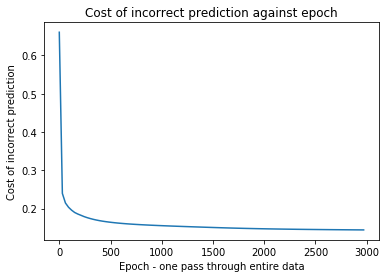

In [44]:
# Training the initialized neuralnet with data X and Y
forward_values, backward_grads = Neuralnet_training(X, Y, parameters, forward_values, backward_grads,
                                                    epochs = 3000, cost_print = 300)

#### Predict the output using trained Neuralnet

In [45]:
# Prediction on training data
pred = Neuralnet_predict(X, parameters, forward_values)
print("Accuracy on training data is {} %".format(np.sum(pred == Y)*100/Y.shape[1]))

Accuracy on training data is 91.75 %


#### Plot the decision boundary of the trained neuralnet classifier

In [46]:
# Function to plot decision boundary
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


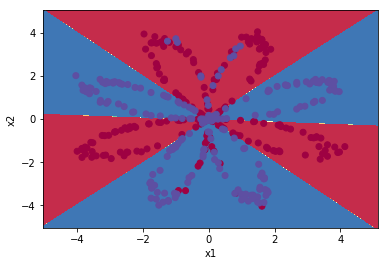

In [47]:
# Plot the decision boundary
plot_decision_boundary(lambda x: Neuralnet_predict(x.T, parameters, forward_values), X, np.squeeze(Y))